In [1]:
!unzip -qq drive/MyDrive/DriveUploader/CheXpert-v1.0-processed_0_4.zip
!mv /content/Users/vpapadop/Documents/GitHub/deep-learning/dataset/CheXpert-v1.0-small/ /content
!cp drive/MyDrive/DriveUploader/train_processed_0_4.csv /content/CheXpert-v1.0-small/

In [2]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.applications.resnet import ResNet152
from keras.preprocessing import image
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Input
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
import seaborn as sns
# matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import datetime
import tensorflow as tf

import json
import cv2

import random


## Dataset Helper class
Let us define several strategies to handle uncertainty.

In [24]:
random.seed(2)

uncertainty_case = {
        0: 0,
        1: 1,
        2: random.randint(0, 1)
    }

class Dataset:
  def __init__(self, path, metadata, size, uncertainty=0, test_case='default'):
    self.test_case = test_case
    self.path = path
    self.metadata = metadata
    self.size = size
    # Load metadata file
    self.df = pd.read_csv(self.path + metadata, nrows = self.size)
    # Fix images path
    self.df['Path'] = self.df['Path'].str.replace('/Users/vpapadop/Documents/GitHub/deep-learning/dataset/','')

    self.handle_uncertainty(uncertainty)
    self.num_classes = len(self.df.columns) - 1 #drop image path column
    self.selected_columns = [col for col in self.df.columns if col != 'Path']

    self.dtrain = None
    self.dvalid = None
    self.dtest = None

    self.class_weights = None

    # train history
    self.models = []
    self.models_history = []
    self.STEP_SIZE_TRAIN = None
    self.STEP_SIZE_VALID= None
    self.STEP_SIZE_TEST= None

  def handle_uncertainty(self, case):
    # handle uncertainty, a_zeros, a_ones, a_random
    for col in self.df.columns:
      if col != 'Path': 
        self.df[col].replace({-1: case}, inplace=True)

  def head(self, n=5):
    return self.df.head(n)

  def histogram(self,axes,pos):
    self.df.iloc[:,1:].sum().plot.barh(ax=axes[pos],title=self.test_case)

  def drop_columns(self, to_drop_list):
    try:
      self.df = self.df.drop(to_drop_list, axis = 1)
    except KeyError as e:
      print(e)

    # self.df = self.df[(self.df['Lung Opacity'] == 1) | (self.df['Pleural Effusion'] == 1) | (self.df['Edema'] == 1) | (self.df['Pneumonia'] == 1) | (self.df['No Finding']) == 1 ]
    self.df.loc[(self.df!=0).any(axis=1)]
    #restore num_classes and selected columns
    self.num_classes = len(self.df.columns) - 1 #drop image path column
    self.selected_columns = [col for col in self.df.columns if col != 'Path']

  def train_test_split(self, size=0.8):
    # random suffle on entire dataset split data into train/valid/test
    self.df = self.df.sample(frac=1)
    # Use (1-size)/2 as validation set
    dvalid_size = round((1-size)/2 * self.df.shape[0])
    # Use (1-size)/2 as test set
    dtest_size = dvalid_size

    self.dtrain = self.df[0:self.df.shape[0]-dvalid_size-dtest_size+1]
    self.dvalid = self.df[self.df.shape[0]-dvalid_size-dtest_size:self.df.shape[0]-dvalid_size+1]
    self.dtest = self.df[self.df.shape[0]-dvalid_size:self.df.shape[0]+1]


  
  def data_generator(self, train_generator, test_generator, valid_generator, batch_size, input_size, shuffle=True):
    self.train_generator=train_generator.flow_from_dataframe(dataframe=self.dtrain, 
                                                      x_col="Path", 
                                                      y_col=list(self.dtrain.columns[1:self.num_classes+1]), 
                                                      class_mode="other",
                                                      target_size=input_size,
                                                      shuffle = shuffle,
                                                      batch_size=batch_size)
    self.valid_generator=valid_generator.flow_from_dataframe(dataframe=self.dvalid , 
                                                      x_col="Path", 
                                                      y_col=list(self.dvalid.columns[1:self.num_classes+1]), 
                                                      class_mode="other",
                                                      target_size=input_size, 
                                                      shuffle = shuffle,
                                                      batch_size=batch_size)
    self.test_generator=test_generator.flow_from_dataframe(dataframe=self.dtest, 
                                                      x_col="Path", 
                                                      y_col=list(self.dtest.columns[1:self.num_classes+1]), 
                                                      class_mode="other",
                                                      target_size=input_size, 
                                                      shuffle = False, batch_size=1)

    self.STEP_SIZE_TRAIN=self.train_generator.n//self.train_generator.batch_size
    self.STEP_SIZE_VALID=self.valid_generator.n//self.valid_generator.batch_size
    self.STEP_SIZE_TEST=self.test_generator.n//self.test_generator.batch_size


  def calculate_weights(self):
    train_samples = pd.DataFrame(self.train_generator.labels, columns = self.selected_columns)  #'Lung Opacity']

    total_samples = len(train_samples)
    self.class_weights = total_samples / ( self.num_classes * train_samples.iloc[:,0:].sum())
    self.class_weights = dict(enumerate(self.class_weights))
    print(self.class_weights)

  def summary(self):
    print(f'Test Case: {self.test_case} - Number of labels: {self.num_classes} - Selected Columns: {self.selected_columns} \
          Train set: {self.dtrain.shape}, Valid set: {self.dvalid.shape}, Test set: {self.dtest.shape}')

We define 3 different case:
* We set all uncertain labels to 0 which is indicates that the label **is not** present in an x-ray.
* We set all uncertain labels to 1 which is indicates that the label **is** present in an x-ray
* We randomly set all uncertain labels to either 0 or 1 based on default **random** number generation distrubion of python.

In [25]:
dataset_cases = [Dataset(path ='CheXpert-v1.0-small/', metadata='train_processed_0_4.csv', 
                         size=100, uncertainty = uncertainty_case[0], test_case='all_zeros'),
                 Dataset(path ='CheXpert-v1.0-small/', metadata='train_processed_0_4.csv', 
                         size=100, uncertainty = uncertainty_case[1], test_case='all_ones'),
                 Dataset(path ='CheXpert-v1.0-small/', metadata='train_processed_0_4.csv', 
                         size=100, uncertainty = uncertainty_case[2], test_case='all_random')]


**plot_histograms** helper function that plots the distribution of labels after handling uncertainty.

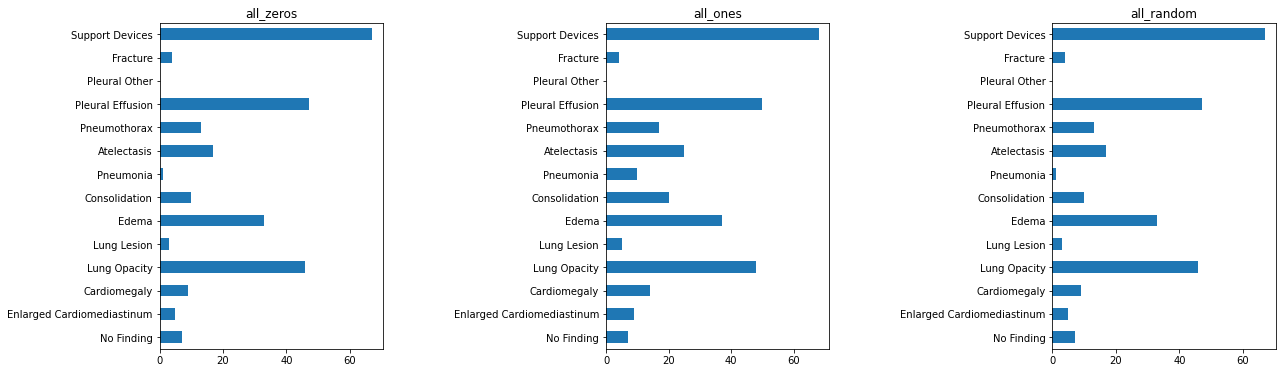

In [26]:
def plot_histograms(dataset_cases):
  # Takes a list of dataset cases and plots histograms
  # Define number of rows and columns for subplots
  
  nrow=1
  ncol=len(dataset_cases)

  # make a list of all dataframes 
  df_list = [d for d in dataset_cases]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 6), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = .5, wspace=1.001)
  count=0
  for col in range(ncol):
    df_list[count].histogram(axes, col)
    count+=1

plot_histograms(dataset_cases)


At this step we can select which colums/labels we want keep in our process. Cause of lack of computation power we drop the majority of the classes.

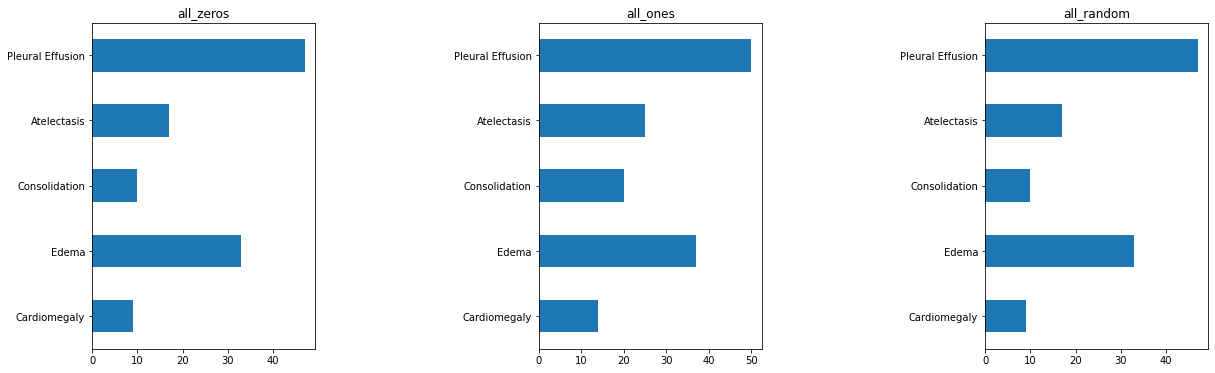

In [27]:
# drop desired columns and plot histograms to check dataset distribution
to_drop = ['Pleural Other', 'Lung Lesion', 
            'Enlarged Cardiomediastinum', 'Fracture', 'No Finding', 
           'Pneumothorax','Fracture', 'Lung Opacity', 'Pneumonia',
           'Support Devices' ]

for case in dataset_cases:
  case.drop_columns(to_drop)


plot_histograms(dataset_cases)


## Split dataset into Train/Valid/Test sets

In [28]:
for case in dataset_cases:
  case.train_test_split(size = 0.8)
  case.summary()

Test Case: all_zeros - Number of labels: 5 - Selected Columns: ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']           Train set: (81, 6), Valid set: (11, 6), Test set: (10, 6)
Test Case: all_ones - Number of labels: 5 - Selected Columns: ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']           Train set: (81, 6), Valid set: (11, 6), Test set: (10, 6)
Test Case: all_random - Number of labels: 5 - Selected Columns: ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']           Train set: (81, 6), Valid set: (11, 6), Test set: (10, 6)


## Data Generation and Dataset Imbalance

* We will use the ImageDatageneration from keras, we create a flow of input data into NN model.
* We will calculate the class-weights of the train set in order to deal with imbalanced datasets

In [29]:
batch_size = 2
input_size = (100, 100)
for case in dataset_cases:
  train_datagen=ImageDataGenerator(rescale=1./255.)
  test_datagen=ImageDataGenerator(rescale=1./255.)
  valid_datagen=ImageDataGenerator(rescale=1./255.)
  print(f'{case.test_case} - Data generator')
  case.data_generator(train_generator=train_datagen,
                      test_generator=test_datagen,
                      valid_generator=valid_datagen,
                      batch_size=batch_size,
                      input_size=input_size,
                      shuffle=True)

all_zeros - Data generator
Found 81 validated image filenames.
Found 11 validated image filenames.
Found 10 validated image filenames.
all_ones - Data generator
Found 81 validated image filenames.
Found 11 validated image filenames.
Found 10 validated image filenames.
all_random - Data generator
Found 81 validated image filenames.
Found 11 validated image filenames.
Found 10 validated image filenames.


In [30]:
for case in dataset_cases:
  print(f'{case.test_case} - Class weights')
  case.calculate_weights()

all_zeros - Class weights
{0: 2.7, 1: 0.54, 2: 1.8, 3: 1.2461538461538462, 4: 0.405}
all_ones - Class weights
{0: 1.4727272727272727, 1: 0.54, 2: 1.08, 3: 0.81, 4: 0.3951219512195122}
all_random - Class weights
{0: 2.3142857142857145, 1: 0.648, 2: 1.8, 3: 1.1571428571428573, 4: 0.3951219512195122}


## Define Model and Metrics

We will use pre-trained model DenseNet121. Since we are dealing with a multi-label classification problem, we need to define usefull metrics that will help to assess the performance of the model.

In [31]:
def get_metrics() :
  return [
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
      # keras.metrics.BinaryAccuracy(name='accuracy'),
      # keras.metrics.Precision(name='precision'),
      # keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### DenseNet121 model creation and Pipeline

In [32]:
def pipeline(models, case, epochs):
  #model architecture design/selection
  #EfficientNetB0/DenseNet121
  # input = tf.keras.Input(shape=(*input_size,3))
  # base_model = tf.keras.applications.DenseNet121(weights='imagenet',
  #                                             include_top = False, 
  #                                             input_tensor = input)

  index = 1
  for base_model in models:
    # Now that we apply global max pooling.
    gap = tf.keras.layers.GlobalMaxPooling2D()(base_model.output)

    # add a fully-connected layer
    fc = tf.keras.layers.Dense(1024, activation='relu')(gap)

    # Finally, we add a classification layer.
    output = tf.keras.layers.Dense(case.num_classes, activation='sigmoid')(fc)

    for layer in base_model.layers:
        layer.trainable = True

    # bind all
    model = tf.keras.Model(base_model.input, output)
    adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 
                          f1_m,precision_m, 
                          recall_m, 
                          get_metrics()])


    print(f'Training case {case.test_case} - model_{index}')
    #Tensorboard
    # log_dir = "logs/"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # Checkpoint to save best model
    save_model_file = f'model_{index}_{case.test_case}.hdf5'
    checkpoint = ModelCheckpoint('drive/MyDrive/DriveUploader/'+ save_model_file, 
                                 save_best_only = True, 
                                 monitor = 'val_loss', 
                                 verbose = 1)

    model_h = model.fit(case.train_generator,
                        steps_per_epoch=case.STEP_SIZE_TRAIN,
                        validation_data=case.valid_generator, 
                        validation_steps=case.STEP_SIZE_VALID, 
                        epochs=epochs,
                        callbacks=[checkpoint],
                        class_weight = case.class_weights)
    
    case.models.append(model)
    case.models_history.append(model_h)
    index += 1


In [33]:
for case in dataset_cases:
  pipeline(models=[tf.keras.applications.DenseNet121(weights='imagenet', 
                                                     include_top = False, 
                                                     input_tensor = tf.keras.Input(shape=(*input_size,3))),
                   tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                        include_top = False, 
                                                        input_tensor = tf.keras.Input(shape=(*input_size,3)))],
                   case = case, epochs = 1)


Training case all_zeros - model_1
40/40 [==============================] - 90s 466ms/step - loss: 1.4887 - accuracy: 0.2152 - f1_m: 0.1405 - precision_m: 0.2171 - recall_m: 0.1317 - auc: 0.5427 - prc: 0.2467 - val_loss: 1.0779 - val_accuracy: 0.4000 - val_f1_m: 0.4556 - val_precision_m: 0.3400 - val_recall_m: 0.8333 - val_auc: 0.5706 - val_prc: 0.2741

Epoch 00001: val_loss improved from inf to 1.07789, saving model to drive/MyDrive/DriveUploader/model_1_all_zeros.hdf5
Training case all_zeros - model_2
40/40 [==============================] - 20s 245ms/step - loss: 2.6364 - accuracy: 0.1519 - f1_m: 0.1262 - precision_m: 0.1723 - recall_m: 0.1412 - auc: 0.5024 - prc: 0.2464 - val_loss: 0.6518 - val_accuracy: 0.3000 - val_f1_m: 0.4276 - val_precision_m: 0.3000 - val_recall_m: 0.9000 - val_auc: 0.5419 - val_prc: 0.2558

Epoch 00001: val_loss improved from inf to 0.65176, saving model to drive/MyDrive/DriveUploader/model_2_all_zeros.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Training case all_ones - model_1
40/40 [==============================] - 32s 472ms/step - loss: 1.2587 - accuracy: 0.2658 - f1_m: 0.2304 - precision_m: 0.2438 - recall_m: 0.2725 - auc: 0.5700 - prc: 0.4046 - val_loss: 1.3096 - val_accuracy: 0.1000 - val_f1_m: 0.3467 - val_precision_m: 0.6000 - val_recall_m: 0.2900 - val_auc: 0.5317 - val_prc: 0.3368

Epoch 00001: val_loss improved from inf to 1.30964, saving model to drive/MyDrive/DriveUploader/model_1_all_ones.hdf5
Training case all_ones - model_2
40/40 [==============================] - 21s 238ms/step - loss: 1.7486 - accuracy: 0.1772 - f1_m: 0.2303 - precision_m: 0.2432 - recall_m: 0.2517 - auc: 0.4975 - prc: 0.2940 - val_loss: 0.7078 - val_accuracy: 0.2000 - val_f1_m: 0.5014 - val_precision_m: 0.4500 - val_recall_m: 0.6500 - val_auc: 0.5792 - val_prc: 0.3371

Epoch 00001: val_loss improved from inf to 0.70784, saving model to drive/MyDrive/DriveUploader/model_2_all_ones.hdf5
Training case all_random - model_1
40/40 [==============

## Training History

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


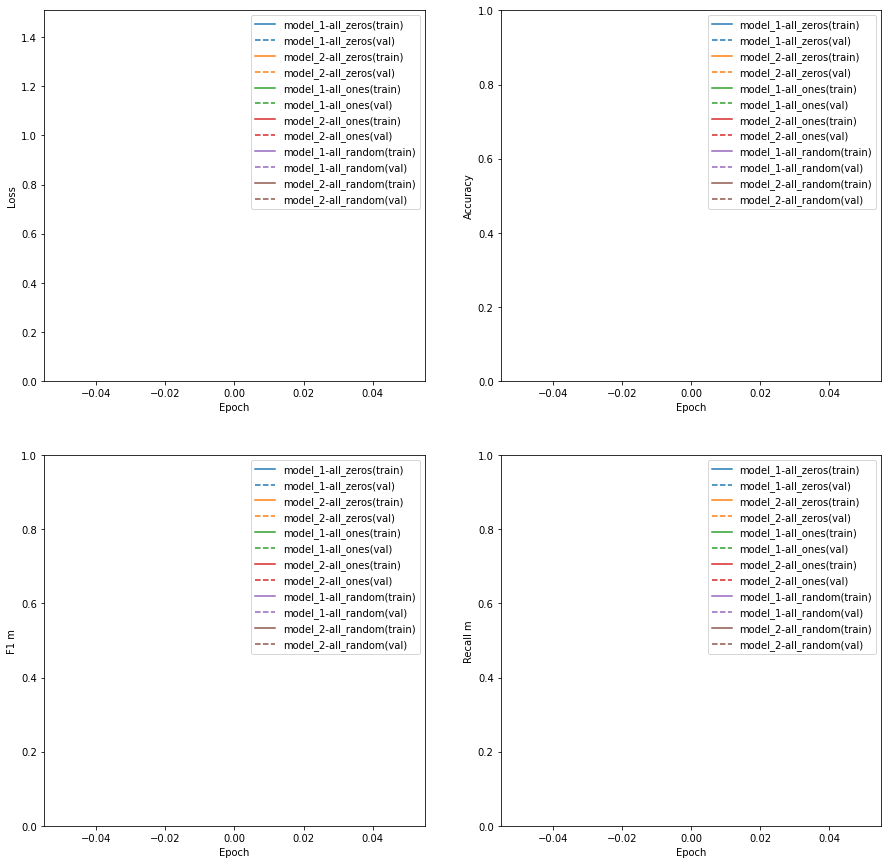

In [35]:
plt.rcParams["figure.figsize"] = (15,15)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(model_history, test_case, metrics, color_index, index):
  # model_history = case.model_history
  # test_case = case.test_case
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(model_history.epoch, model_history.history[metric], color=colors[color_index], label=f'model_{index}-{test_case}(train)')
    plt.plot(model_history.epoch, model_history.history['val_'+metric],
             color=colors[color_index], linestyle="--", label=f'model_{index}-{test_case}(val)')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

color_index = 0

eval_metrics = ['loss', 'accuracy','f1_m', 'recall_m']
for case in dataset_cases:
  index = 1
  for history in case.models_history:
    plot_metrics(history, case.test_case,eval_metrics , color_index, index)
    color_index +=1
    index +=1


## Evaluation Metrics
You can use a confusion matrix to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label

Evaluating case all_zeros-model_1
10/10 [==============================] - 2s 49ms/step


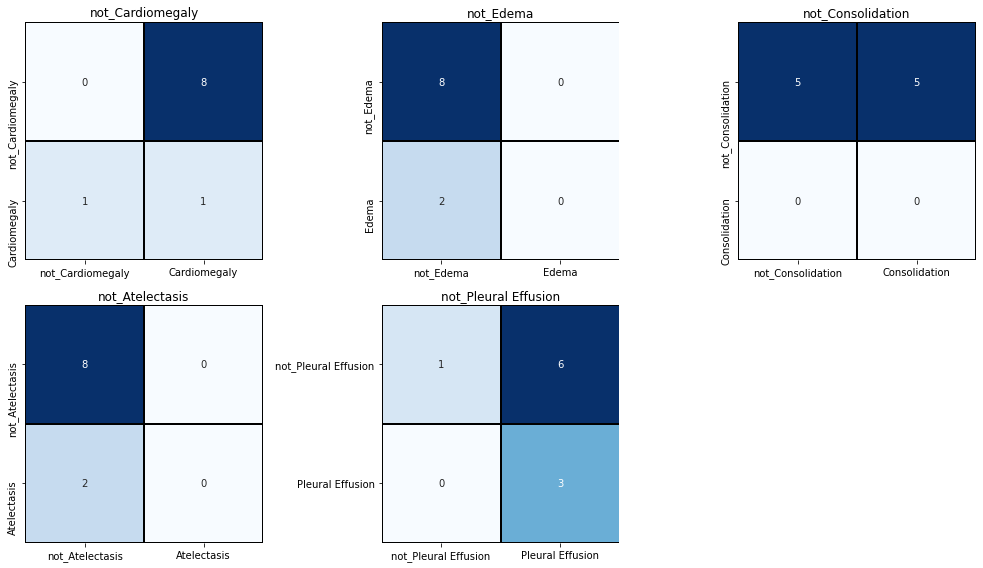

Evaluating case all_zeros-model_2
10/10 [==============================] - 2s 26ms/step


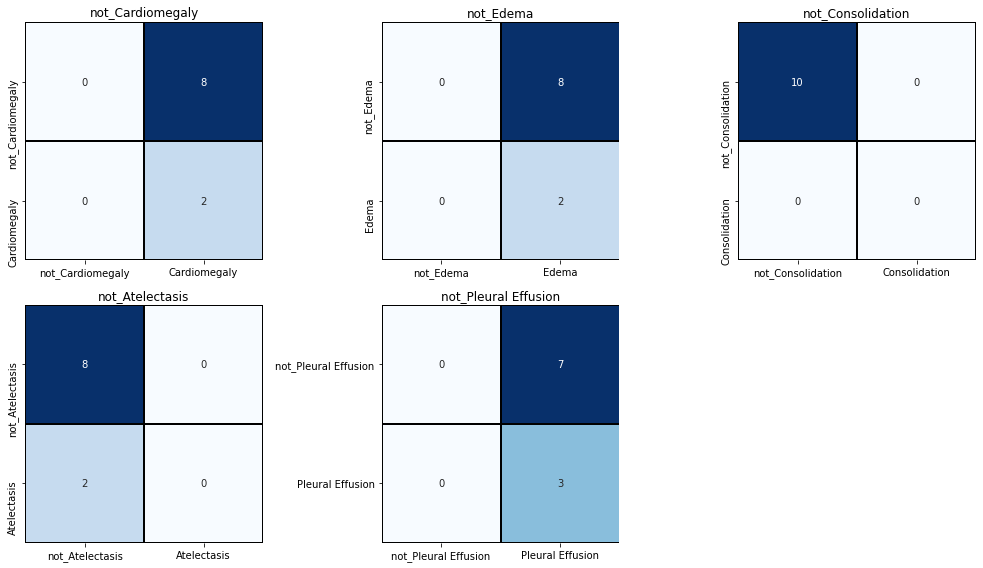

Evaluating case all_ones-model_1
10/10 [==============================] - 2s 46ms/step


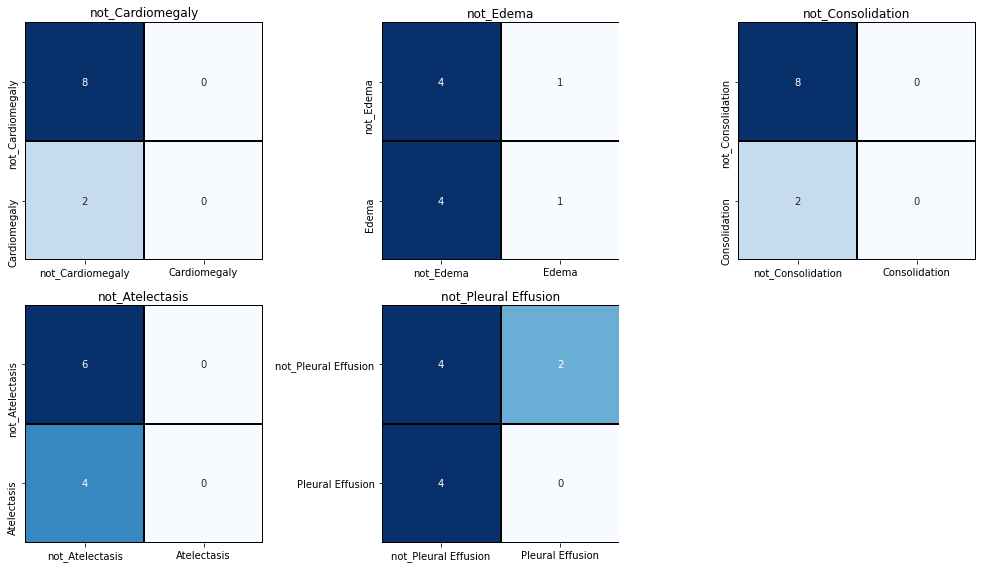

Evaluating case all_ones-model_2
10/10 [==============================] - 2s 26ms/step


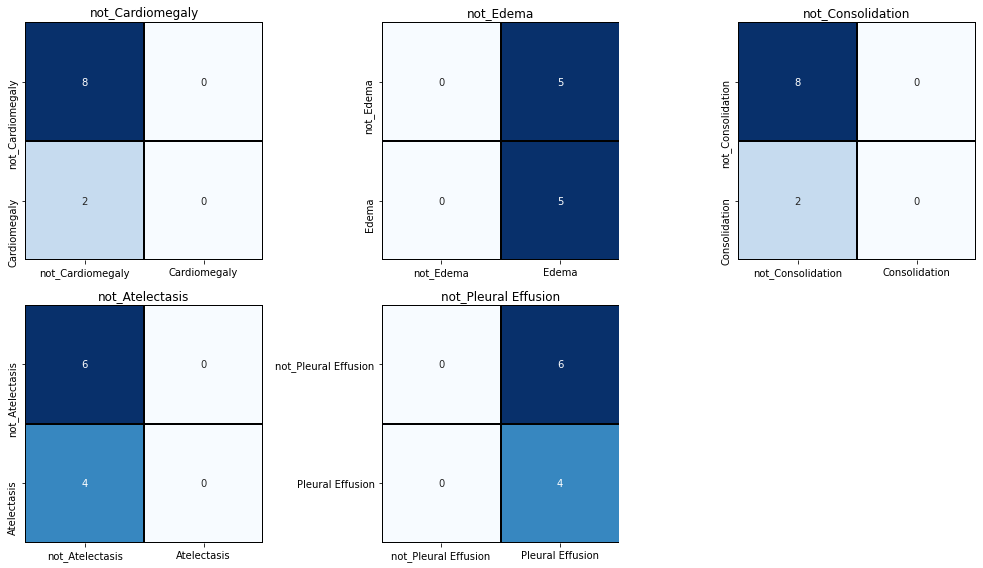

Evaluating case all_random-model_1
10/10 [==============================] - 2s 49ms/step


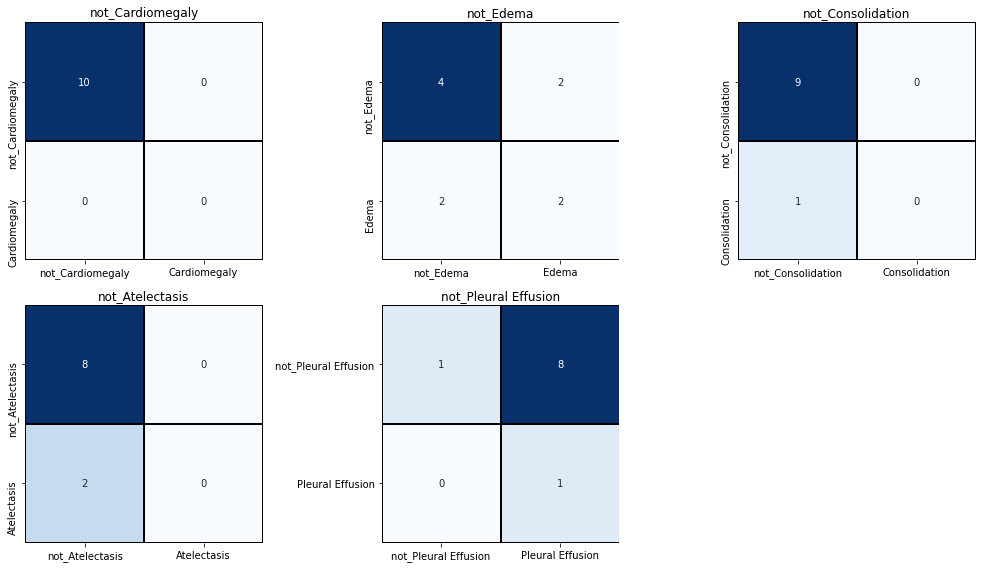

Evaluating case all_random-model_2
10/10 [==============================] - 2s 29ms/step


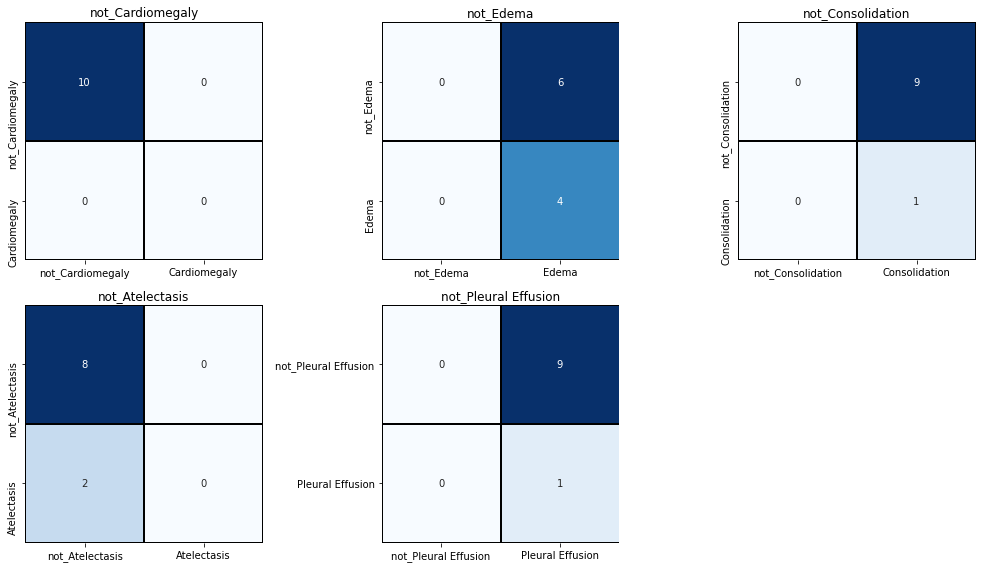

In [36]:
from sklearn.metrics import multilabel_confusion_matrix
for case in dataset_cases:
  index = 1
  for model in case.models:
    print(f'Evaluating case {case.test_case}-model_{index}')
    # Predicting test images
    preds = model.predict(case.test_generator, steps=case.STEP_SIZE_TEST, verbose=1)
    preds = np.where(preds < 0.5, 0, 1)

    y_true = case.test_generator.labels
    classes = case.df.columns[1:case.num_classes+1]

    # Creating multilabel confusion matrix
    confusion = multilabel_confusion_matrix(y_true, preds)
    # Plot confusion matrix 
    fig = plt.figure(figsize = (14, 8))
    for i, (label, matrix) in enumerate(zip(classes, confusion)):
        plt.subplot(f'23{i+1}')
        labels = [f'not_{label}', label]
        sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                    xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
        plt.title(labels[0])
        
    index += 1
    plt.tight_layout()
    plt.show()

## AUROC

ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). 

* Classifiers that give curves closer to the top-left corner indicate a better performance. 
* A random classifier is expected to give points lying along the diagonal (FPR = TPR).
* The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

Evaluating AUROC for case all_zeros - model_1
10/10 [==============================] - 1s 47ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


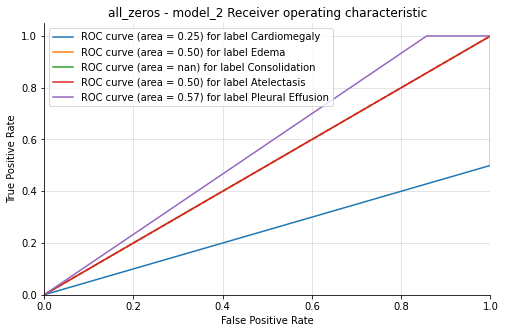

Evaluating AUROC for case all_zeros - model_2
10/10 [==============================] - 0s 28ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


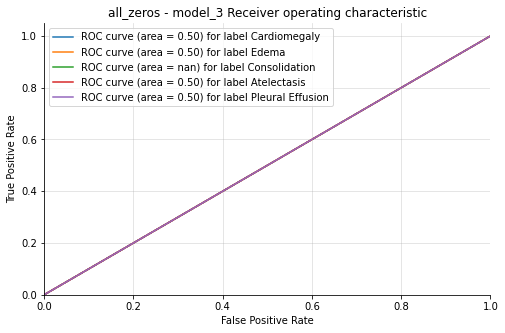

Evaluating AUROC for case all_ones - model_1
10/10 [==============================] - 1s 52ms/step


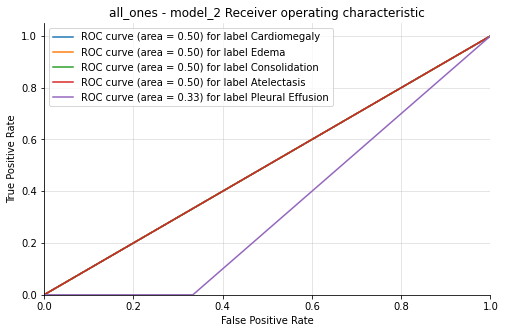

Evaluating AUROC for case all_ones - model_2
10/10 [==============================] - 0s 27ms/step


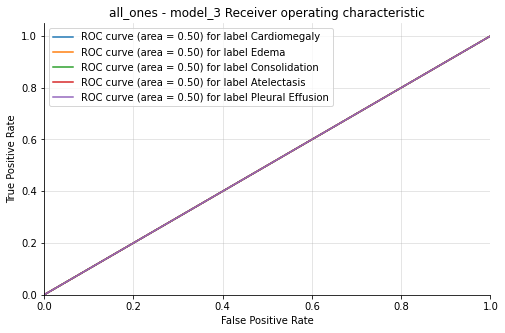

Evaluating AUROC for case all_random - model_1
10/10 [==============================] - 1s 49ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


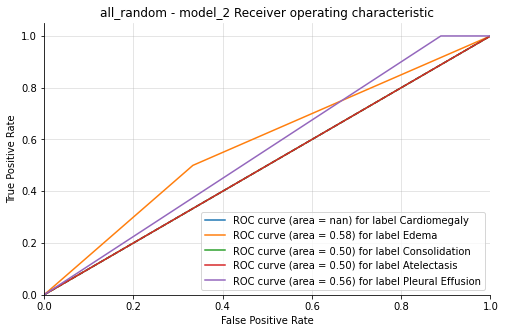

Evaluating AUROC for case all_random - model_2
10/10 [==============================] - 0s 26ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


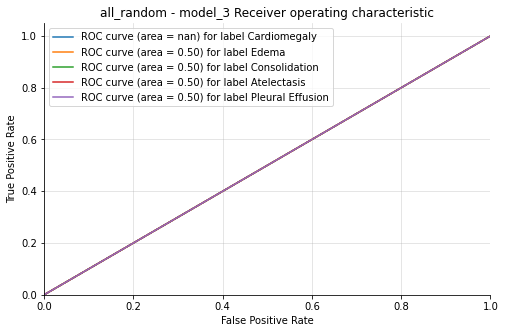

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# helper function
def plot_multiclass_roc(y_test, y_probs, model, labels, figsize=(17, 6)):
    
    n_classes = len(labels)
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # roc for each class
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model} Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


for case in dataset_cases:
  index = 1
  for model in case.models:
    print(f'Evaluating AUROC for case {case.test_case} - model_{index}')
    # Predicting test images
    preds = model.predict(case.test_generator, steps=case.STEP_SIZE_TEST, verbose=1)
    preds = np.where(preds < 0.5, 0, 1)

    y_true = case.test_generator.labels
    classes = case.df.columns[1:case.num_classes+1]
    index += 1
    plot_multiclass_roc(y_true, preds, f'{case.test_case} - model_{index}', classes, figsize = (8,5))

## Gradient-weighted Class Activation Mapping (Grad-CAM)

Using Grad-CAM, we can visually validate in which region in the image our network is looking, verifying that it is indeed looking at the correct patterns in the image and activating around those patterns.

If the network is not activating around the proper patterns/objects in the image, then we know:

* Our network hasn’t properly learned the underlying patterns in our dataset
* Our training procedure needs to be revisited
* We may need to collect additional data



In [40]:
# NOTE this cell has been taken from keras documentation

from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
for idx in range(len(dataset_cases[0].model.layers):
  print(dataset_cases[0].model.get_layer(index = idx).name)

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [ ]:
for case in dataset_cases:
  image = case.test_generator[0][0]
  model = case.model
  prediction = model.predict(image) 
  i = np.argmax(prediction[0])
  # print(prediction)
  
  icam = GradCAM(model, i, 'conv5_block16_2_conv')  # efnet'block5c_project_conv'
  heatmap = icam.compute_heatmap(image)
  heatmap = cv2.resize(heatmap, input_size)

  # image = cv2.imread(test_image)
  # image = cv2.resize(image, input_size)
  print(heatmap.shape, image[0].shape)
  # print(heatmap, image[0])
  # alpha = np.full(input_size, 128, dtype=np.uint8)
  # image[0] = np.dstack((image, alpha))
  (heatmap, output) = icam.overlay_heatmap(heatmap, image[0], alpha=0.5)

  # fig, ax = plt.subplots(1, 3)
  # ax[1].set_title(f'{case.test_case} - {prediction}')
  # ax[0].imshow(heatmap)
  # ax[1].imshow(image)
  # ax[2].imshow(output)

(100, 100) (100, 100, 3)


error: ignored